In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet

from albumentations import *
from albumentations.pytorch import ToTensorV2


import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import scipy.ndimage

import umap
import seaborn as sns

In [17]:
dataname_biop="pca_detect_dense_2mpp_AllCancer_bps"
dataname_wsi = "pca_detect_dense_small"

In [18]:
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        #print(fname)
        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]                        
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            img = self.imgs[index,:,:,:]
            label = self.labels[index]
        
        
        img_new = img
        
        if self.img_transform:
            img_new = self.img_transform(image=img)['image']

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [19]:
batch_size = 256
phases = ["train", "val"]
dataset_biop={}
dataLoader_biop={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset_biop[phase]=Dataset(f"./{dataname_biop}_{phase}.pytable", img_transform=None)
    dataLoader_biop[phase]=DataLoader(dataset_biop[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"Biopsy {phase} dataset size:\t{len(dataset_biop[phase])}")
    
dataset_wsi={}
dataLoader_wsi={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset_wsi[phase]=Dataset(f"./{dataname_wsi}_{phase}.pytable", img_transform=None)
    dataLoader_wsi[phase]=DataLoader(dataset_wsi[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"Whole Slide Image {phase} dataset size:\t{len(dataset_wsi[phase])}")

Biopsy train dataset size:	1207
Biopsy val dataset size:	386
Whole Slide Image train dataset size:	5204
Whole Slide Image val dataset size:	1087


In [20]:
tile_size = 224
biop_data = np.zeros((len(dataset_biop["val"]) + len(dataset_biop["train"]), tile_size, tile_size, 3))
biop_labels = []
start = 0
for ii , (X, label, img_orig) in enumerate(dataLoader_biop["val"]):
    biop_data[start:(start + np.shape(X)[0]), :,:,:] = X
    [biop_labels.append(a) for a in label.tolist()]
    start += np.shape(X)[0]
for ii , (X, label, img_orig) in enumerate(dataLoader_biop["train"]):
    biop_data[start:(start + np.shape(X)[0]), :,:,:] = X
    [biop_labels.append(a) for a in label.tolist()]
    start += np.shape(X)[0]

In [21]:
tile_size = 224
wsi_data = np.zeros((len(dataset_wsi["val"]) + len(dataset_wsi["train"]), tile_size, tile_size, 3))
wsi_labels = []
start = 0
for ii , (X, label, img_orig) in enumerate(dataLoader_wsi["val"]):
    wsi_data[start:(start + np.shape(X)[0]), :,:,:] = X[:,(128 - (tile_size//2)):(128 + (tile_size//2)),(128 - (tile_size//2)):(128 + (tile_size//2)), :]
    [wsi_labels.append(a) for a in label.tolist()]
    start += np.shape(X)[0]
for ii , (X, label, img_orig) in enumerate(dataLoader_wsi["train"]):
    wsi_data[start:(start + np.shape(X)[0]), :,:,:] = X[:,(128 - (tile_size//2)):(128 + (tile_size//2)),(128 - (tile_size//2)):(128 + (tile_size//2)), :]
    [wsi_labels.append(a) for a in label.tolist()]
    start += np.shape(X)[0]

In [22]:
img_type_label = np.zeros((len(wsi_labels)))
img_type_label = np.concatenate((img_type_label, np.ones((len(biop_labels)))), axis=0)
cancer_label = np.concatenate((biop_labels, wsi_labels), axis=0)
data = np.vstack([biop_data, wsi_data]) / 255.0
data = data.reshape(np.shape(data)[0], -1)
print(data.shape)

(7884, 150528)


In [23]:
print(f"Biopsy Data Shape: {np.shape(biop_data)}")
print(f"Whole Slide Image Data Shape: {np.shape(wsi_data)}")

Biopsy Data Shape: (1593, 224, 224, 3)
Whole Slide Image Data Shape: (6291, 224, 224, 3)


In [24]:
# embedding = umap.UMAP(n_neighbors=5).fit_transform(data)
# print("First Embedding")

In [25]:
# print(np.shape(data))
# thresh00 = np.percentile(embedding[:,0], 95)
# thresh01 = np.percentile(embedding[:,0], 5)
# thresh10 = np.percentile(embedding[:,1], 95)
# thresh11 = np.percentile(embedding[:,1], 5)

# remove1 = np.logical_or((embedding[:,0] > thresh00),(embedding[:,0] < thresh01))
# remove2 = np.logical_or((embedding[:,1] > thresh10),(embedding[:,1] < thresh11))
# # remove1 = np.logical_or((embedding[:,0] > (4 * np.mean(embedding[:,0]))),(embedding[:,0] > (np.mean(embedding[:,0]) / 4)))
# # remove2 = np.logical_or((embedding[:,1] > (4 * np.mean(embedding[:,1]))),(embedding[:,1] > (np.mean(embedding[:,1]) / 4)))
# remove = remove1 | remove2
# print(np.sum(remove * 1))

In [26]:
# np.savetxt("keep.txt", remove * 1)

# data = np.delete(data, remove, axis = 0)
# print(np.shape(data))
# print("Deleted")
# img_type_label = np.delete(img_type_label, remove, axis = 0)
# cancer_label = np.delete(cancer_label, remove, axis = 0)


In [27]:
remove = np.loadtxt("keep.txt") > 0
remove = np.logical_not(remove)
# img_type_label = np.delete(img_type_label, remove, axis = 0)
# cancer_label = np.delete(cancer_label, remove, axis = 0)
# data = np.delete(data, remove, axis = 0)
data = data[remove, :]
img_type_label = img_type_label[remove]
cancer_label = cancer_label[remove]
print(np.shape(data))

(6306, 150528)


In [28]:
x = [True ,True, False]
y = [z is False for z in x]
# print(y)

(6306,)
(6306,)
(6306, 2)


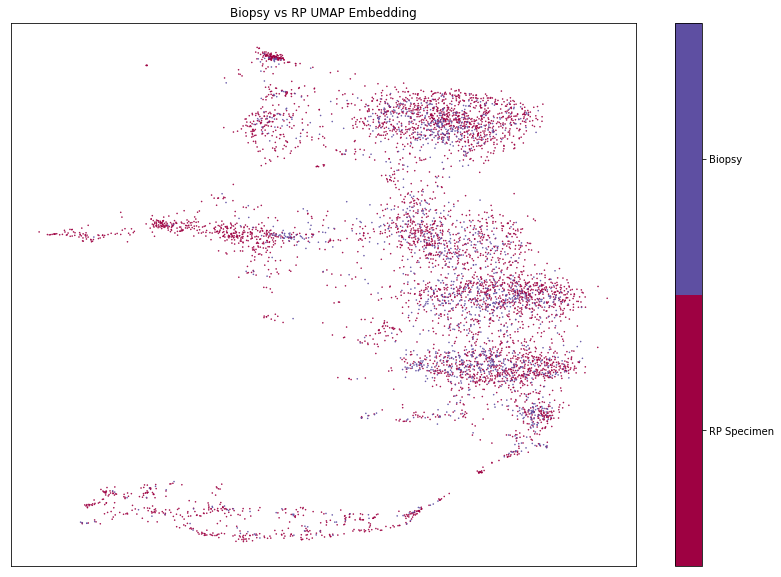

In [37]:
# embedding = umap.UMAP(n_neighbors=5).fit_transform(data)

# target = img_type_label
classes = [ "RP Specimen","Biopsy"]
# print(np.shape(embedding[:,0]))
# rem = embedding[:,0] > 4
# print(np.shape(rem))
# print(np.shape(embedding))
# embedding = embedding[rem, :]
# target = target[rem]
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.rcParams.update({'font.size': 22})
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes)
plt.title('Biopsy vs RP UMAP Embedding')

fig.savefig('biop_wsi_umap.png', dpi=300)

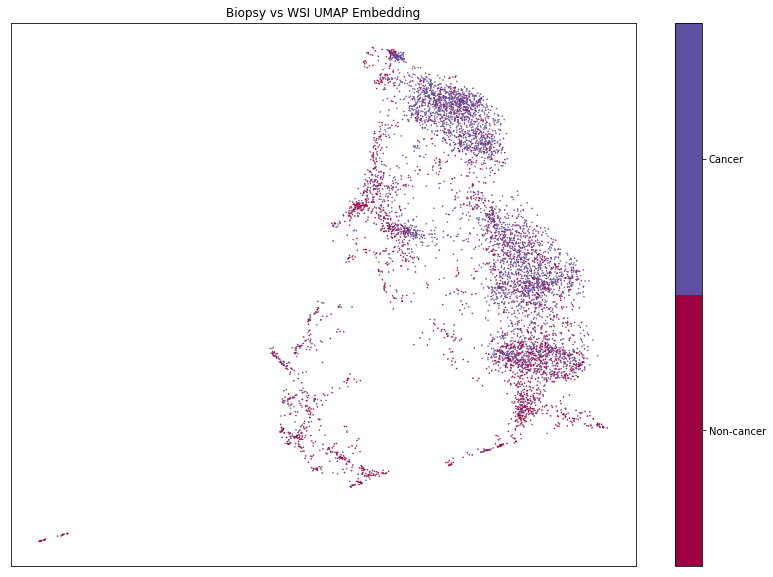

In [85]:
target = cancer_label
classes = ["Non-cancer","Cancer"]

fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes)
plt.title('Biopsy vs WSI UMAP Embedding');

# fig.savefig('biop_wsi_umap2.png', dpi=300)

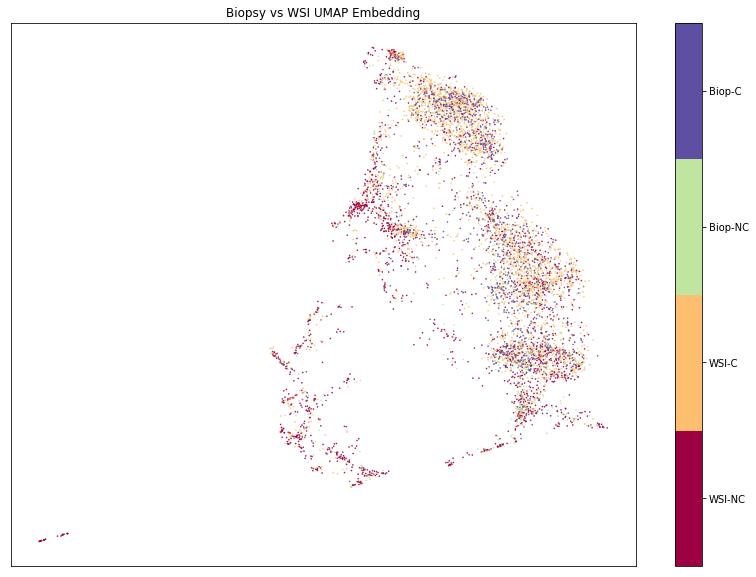

In [86]:
all_labels = np.zeros(cancer_label.shape)
all_labels[np.logical_and(cancer_label==0, img_type_label==0)] = 0
all_labels[np.logical_and(cancer_label==1, img_type_label==0)] = 1
all_labels[np.logical_and(cancer_label==0, img_type_label==1)] = 2
all_labels[np.logical_and(cancer_label==1, img_type_label==1)] = 3

target = all_labels
classes = ["WSI-NC","WSI-C", "Biop-NC", "Biop-C"]

fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title('Biopsy vs WSI UMAP Embedding');

# fig.savefig('biop_wsi_umap3.png', dpi=300)

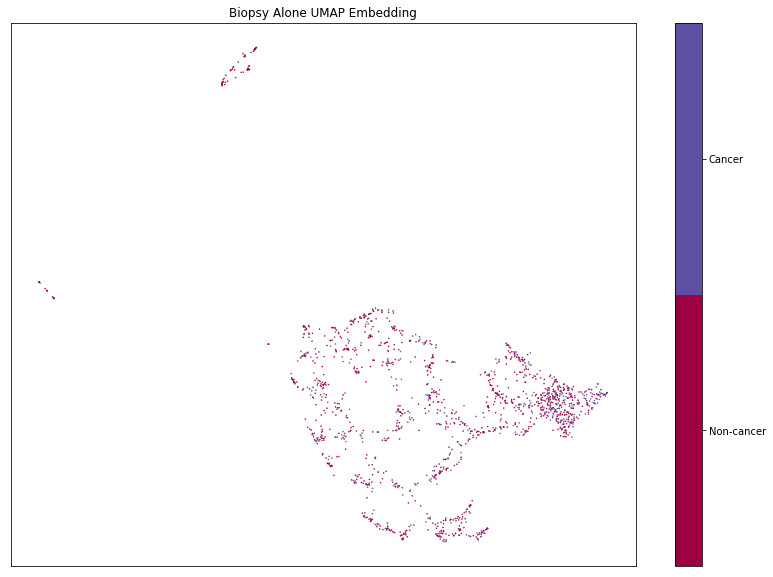

In [87]:
bdata = biop_data.reshape(np.shape(biop_data)[0], -1)
embeddingb = umap.UMAP(n_neighbors=5).fit_transform(bdata)

target = np.array(biop_labels)
classes = ["Non-cancer","Cancer"]

fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(*embeddingb.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes)
plt.title('Biopsy Alone UMAP Embedding');

fig.savefig('biopsy_umap.png', dpi=300)

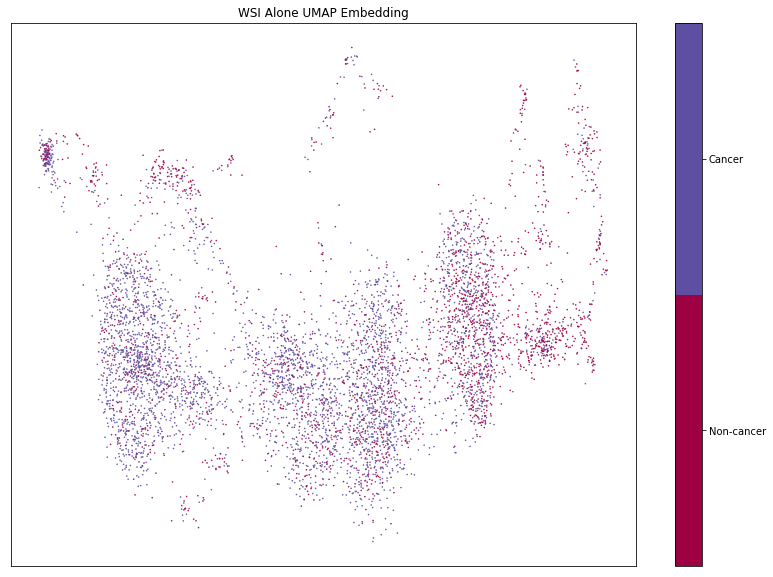

In [88]:
wdata = wsi_data.reshape(np.shape(wsi_data)[0], -1)
embeddingw = umap.UMAP(n_neighbors=5).fit_transform(wdata)

target = np.array(wsi_labels)
classes = ["Non-cancer","Cancer"]

fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(*embeddingw.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes)
plt.title('WSI Alone UMAP Embedding');

fig.savefig('wsi_umap.png', dpi=300)

(6306, 2)


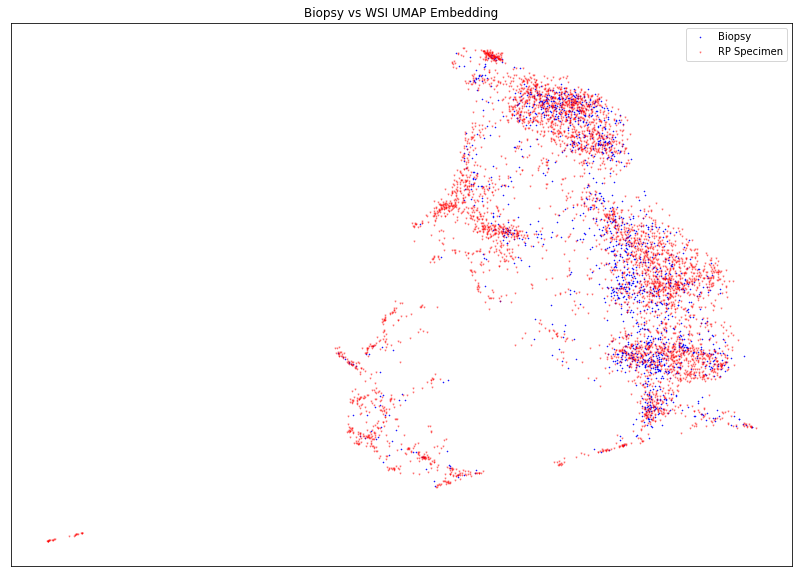

In [89]:
print(embedding.shape)
target = img_type_label
classes = [ "WSI","Biopsy"]

fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(embedding[target == 1][:,0],embedding[target == 1][:,1] , s=0.3, color = 'blue', marker = 'o', alpha = 1)
plt.scatter(embedding[target == 0][:,0],embedding[target == 0][:,1], s=1, color = "red", marker = 'v', alpha = .5)
plt.legend(['Biopsy', 'RP Specimen'])
plt.setp(ax, xticks=[], yticks=[])
# cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
# cbar.set_ticks(np.arange(2))
# cbar.set_ticklabels(classes)
plt.title('Biopsy vs WSI UMAP Embedding');
fig.savefig('biop_wsi_umap.png', dpi=1000)

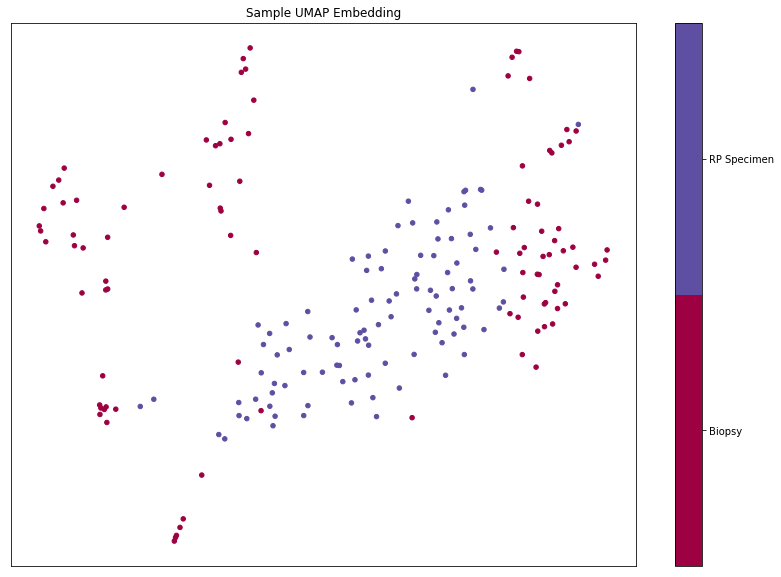

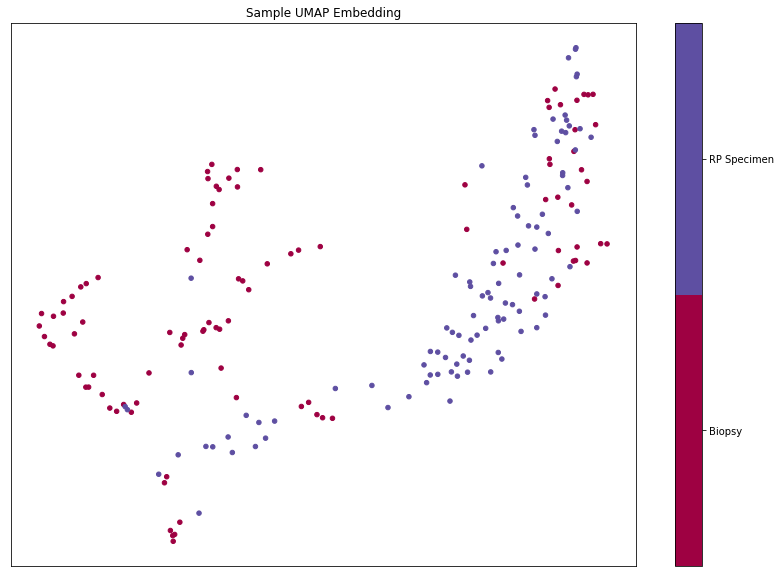

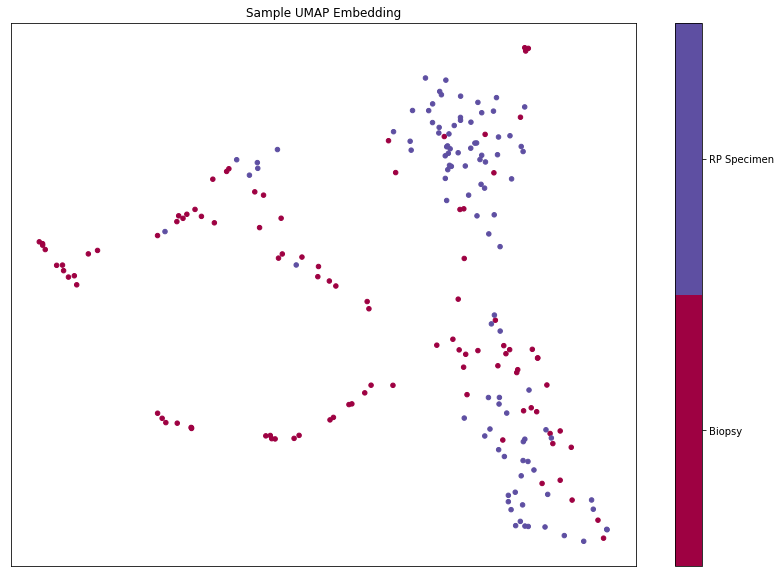

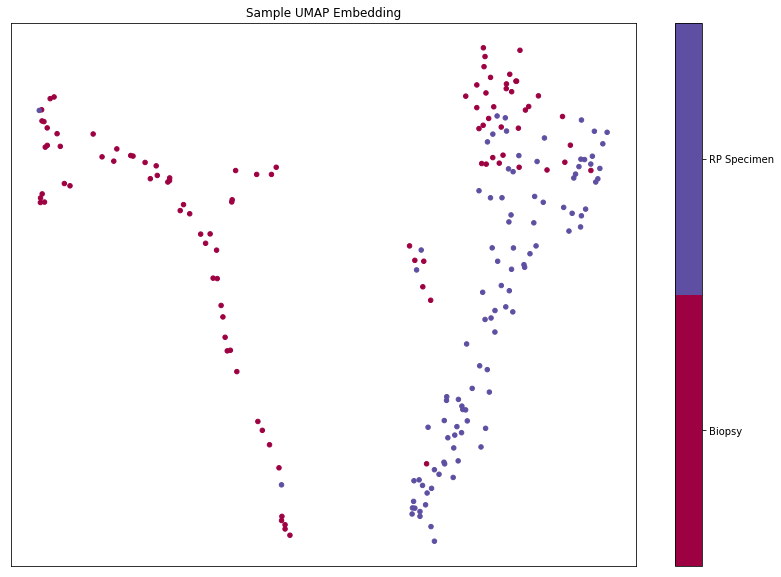

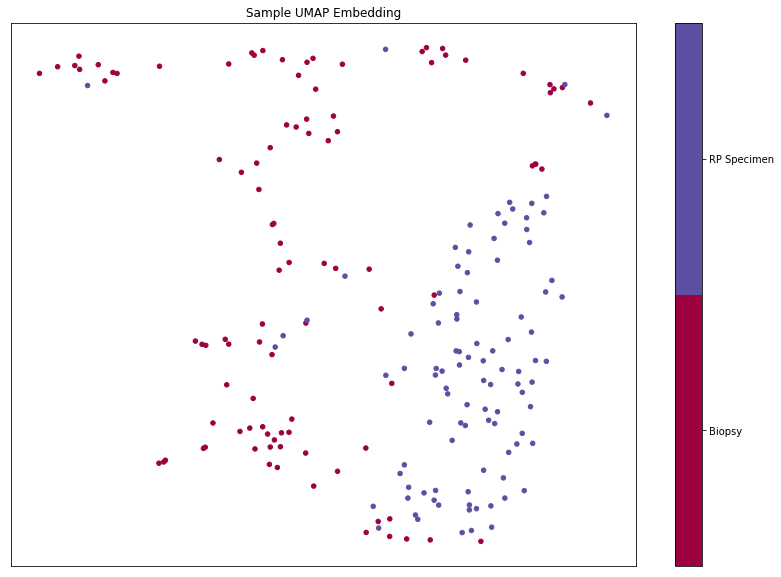

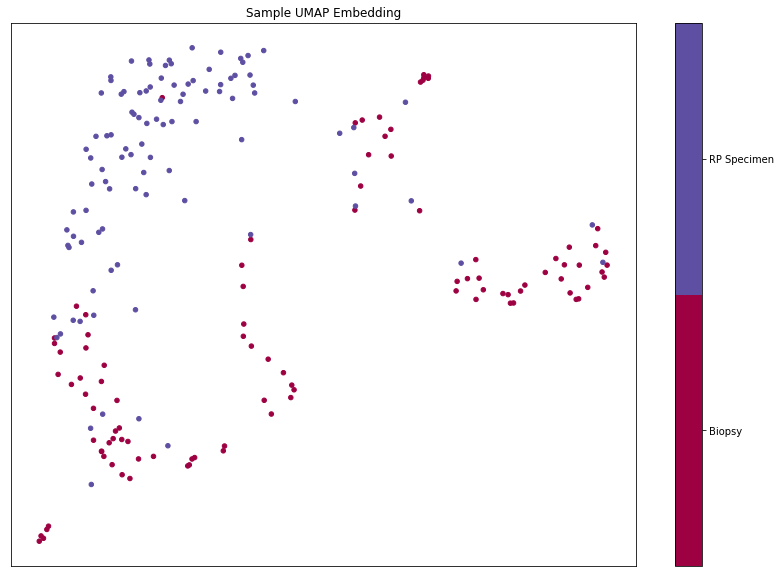

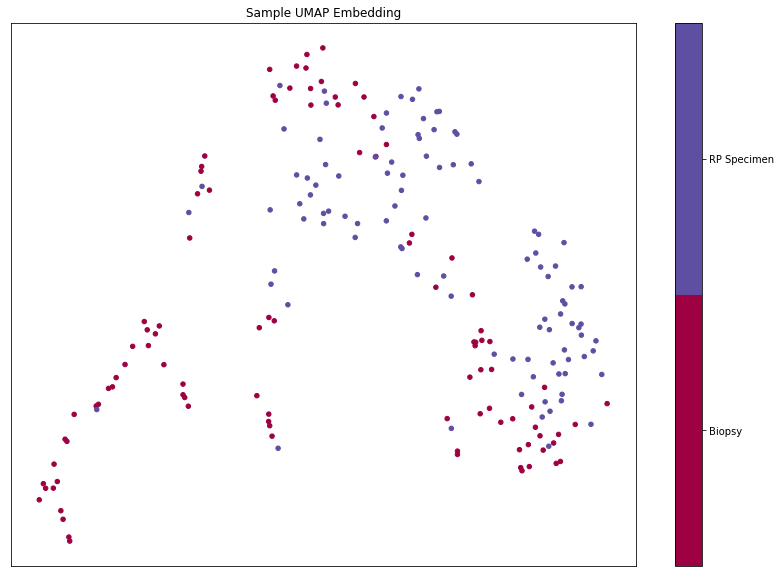

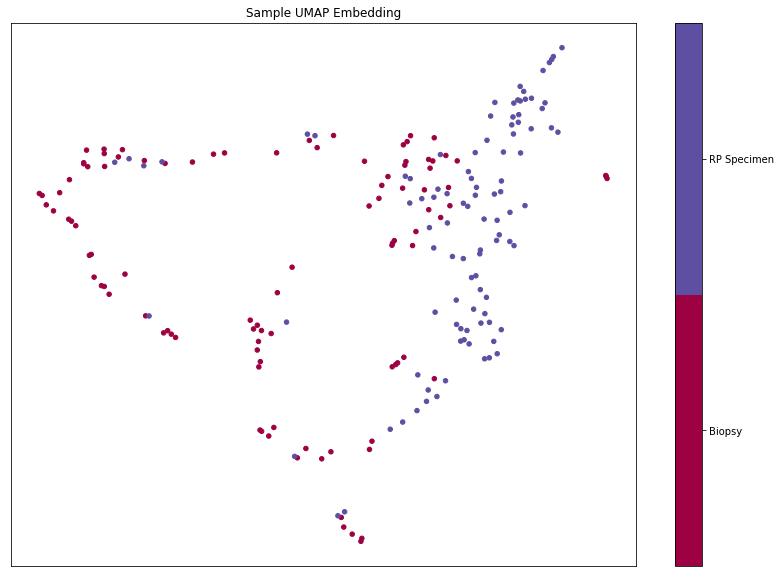

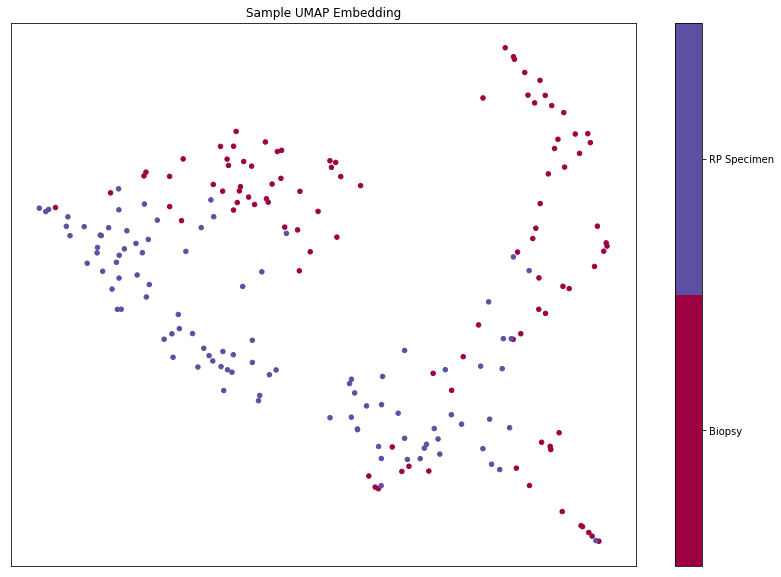

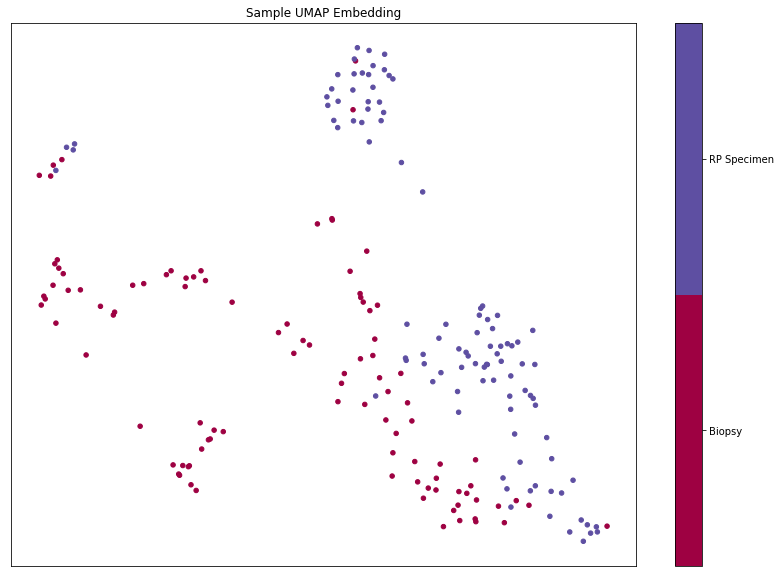

In [90]:
for i in np.arange(10):
    bsample = np.copy(bdata)
    p = np.random.permutation(len(biop_labels))
    bsample = bsample[p][:100]
    blabels = np.array(biop_labels)[p][:100]

    rsample = np.copy(wdata)
    p = np.random.permutation(len(wsi_labels))
    rsample = rsample[p][:100]
    rlabels = np.array(wsi_labels)[p][:100]

    rblabels = np.zeros((100))
    rblabels = np.concatenate((rblabels, np.ones((100))), axis=0)

    datasample = np.vstack([bsample, rsample]) / 255.0
    cancerlabels = np.vstack([blabels, rlabels]).T

    embeddingsmall = umap.UMAP(n_neighbors=5).fit_transform(datasample)

    target = np.array(rblabels)
    classes = ["Biopsy","RP Specimen"]

    fig, ax = plt.subplots(1, figsize=(14, 10))

    plt.scatter(*embeddingsmall.T, s=20, c=target, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
    cbar.set_ticks(np.arange(2))
    cbar.set_ticklabels(classes)
    plt.title('Sample UMAP Embedding');

    fig.savefig("sample_umap" + f"{i}" + ".png", dpi=500)

In [91]:
print(np.shape(datasample))
print(np.shape(cancerlabels))

(200, 150528)
(100, 2)
